## Multi-layer perceptron (MLP)
In this second notebook of makemore, we are going to implement a MLP. The drawback of our previous approach is that the dimensionality of n-grams scale exponentially as we increase n. Hence, we want a more robust method that does not computationally scale exponentially.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
len(words)

32033

In [6]:
# create mapping from characters to integers and vice versa
# special character . denotes start and end of name, and is given a '0'
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Next, we create the dataset.

In [8]:
block_size = 3 # context length: how many characters we take to predict the next character
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [10]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [11]:
def build_dataset(words):
    block_size = 3 # context length: how many characters we take to predict the next character
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

Next, we create our train, val and test sets.

In [12]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

In [13]:
X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [14]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # 27 characters, embedding size 10
W1 = torch.randn((30, 200) , generator=g) # 30 = 3 * 10, 200 is magic number for hidden dim
b1 = torch.randn((200,), generator=g)
W2 = torch.randn((200, 27), generator=g) # 27 as we need to predict out of 27 characters
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]

In [15]:
num_parameters = sum([p.numel() for p in parameters])
num_parameters

11897

In [16]:
for p in parameters:
    p.requires_grad = True

In [17]:
# to find best learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [18]:
# to keep track of learning rate and respective loss
lri = []
lossi = []
stepi = []

In [19]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (32,))
  
  # forward pass
  emb = C[X_train[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y_train[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # learning rate decay update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())


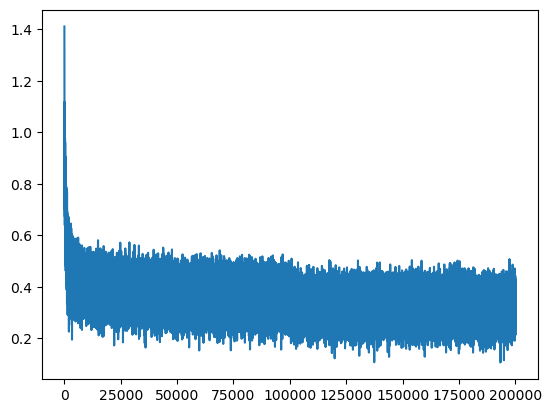

In [20]:
plt.plot(stepi, lossi)

We see that the training loss fluctuates because we are taking mini-batches. We can calculate our train and validation loss.

In [22]:
emb = C[X_train]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Y_train)
train_loss

tensor(2.1423, grad_fn=<NllLossBackward0>)

In [23]:
emb = C[X_val]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, Y_val)
val_loss

tensor(2.1828, grad_fn=<NllLossBackward0>)

Train and validation losses are very similar, which means that we are not overfitting. Lastly, we want to sample from the model and generate some names.

In [30]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
quilli.
khy.
mis.
rehty.
skanden.
jazhite.
deliah.
jareei.
nermara.
chaiivin.
legend.
bron.
cateen.
tis.
lilea.
jadia.
wajermadiarixik.
kael.
dusabee.


This is actually not bad! We are starting to see some patterns of name-like words appearing.